In [1]:
# Import necessary libraries and check GPU availability
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and will be used.")
else:
    print("GPU is not available, using CPU instead.")

GPU is available and will be used.


In [2]:
# Dataset paths (fold5-selected)
train_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train'
valid_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold5/Valid'
test_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold5/Test'

In [3]:
img_size = (224, 224)
batch_size = 16

In [4]:
# Function to create data augmentation pipelines
def augment_class_specific(class_name):
    if class_name in ['Chickenpox', 'Monkeypox']:
        # More aggressive augmentations for Chickenpox and Monkeypox
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=60,
            width_shift_range=0.5,
            height_shift_range=0.5,
            shear_range=0.4,
            zoom_range=0.5,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.5, 1.5],
            fill_mode='nearest',
            preprocessing_function=lambda img: tf.image.random_contrast(img, lower=0.8, upper=1.2)
        )
    else:
        # Lighter augmentations for other classes
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.4,
            height_shift_range=0.4,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.7, 1.3],
            fill_mode='nearest'
        )

# Test data augmentation (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Function to load data with class-specific augmentations
def load_data():
    train_datagen = augment_class_specific("Chickenpox")
    validation_datagen = augment_class_specific("Monkeypox")
    
    train_generator = train_datagen.flow_from_directory(
        train_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        valid_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = load_data()

Found 7532 images belonging to 6 classes.
Found 154 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


In [6]:
# Check class indices to ensure they are correct
print(f"Class indices for the training data: {train_generator.class_indices}")

Class indices for the training data: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}


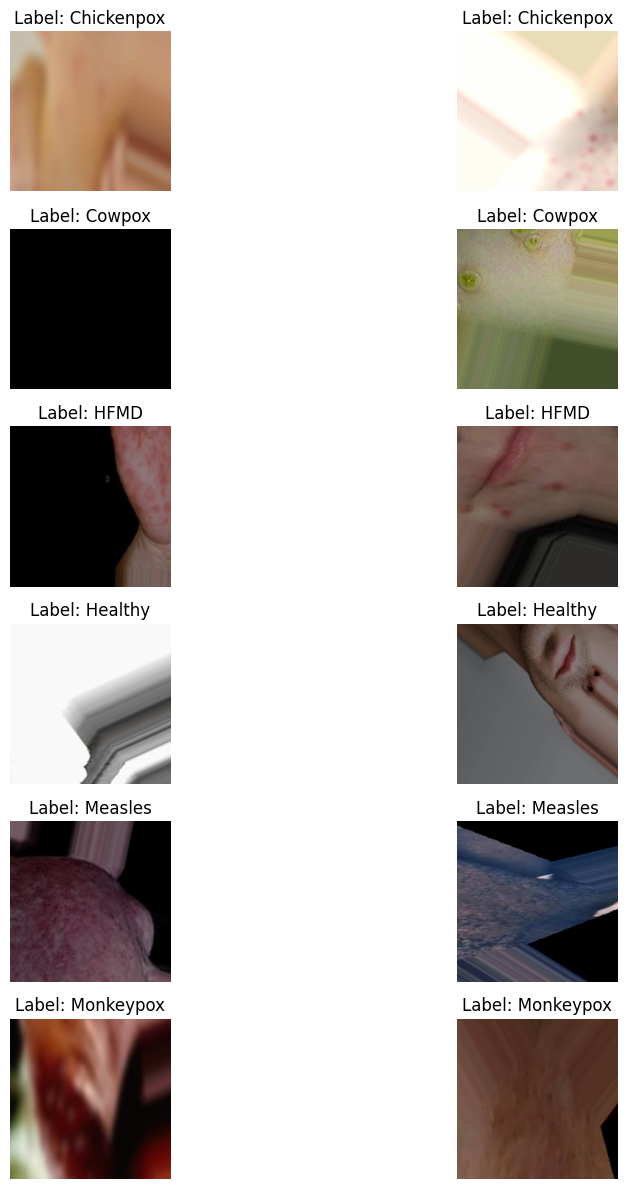

In [7]:
def plot_images_per_class(generator, num_images_per_class=2):
    # Invert the class_indices dictionary to get label -> class name mapping
    class_indices = {v: k for k, v in generator.class_indices.items()}
    num_classes = len(class_indices)
    
    # Initialize a dictionary to store images for each class
    images_per_class = {class_name: [] for class_name in class_indices.values()}

    # Loop until we have collected enough images for each class
    while any(len(images) < num_images_per_class for images in images_per_class.values()):
        images, labels = next(generator)
        
        # Process each image in the batch
        for img, label in zip(images, labels):
            class_label = np.argmax(label)  # Find the index of the one-hot encoded label
            class_name = class_indices[class_label]  # Get the class name from the class indices
            
            # Only add if we haven't collected enough images for this class
            if len(images_per_class[class_name]) < num_images_per_class:
                images_per_class[class_name].append(img)
    
    # Now that we have enough images, let's plot them
    plt.figure(figsize=(12, num_classes * 2))  # Adjust the figure size based on the number of classes
    img_idx = 1
    for class_name, images in images_per_class.items():
        for img in images:
            plt.subplot(num_classes, num_images_per_class, img_idx)
            img_idx += 1
            
            # Scale the image if necessary
            if img.max() > 1:
                img = img / 255.0
            
            plt.imshow(img)
            plt.title(f"Label: {class_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 2 images from each class from the training set
plot_images_per_class(train_generator, num_images_per_class=2)

In [8]:
# Compute class weights to handle imbalance
labels = train_generator.classes
class_weights_inception = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(labels), 
                                                  y=labels)
class_weights_dict_inception = dict(enumerate(class_weights_inception))

In [9]:
# Build the InceptionV3 model
def build_inceptionv3_model(input_shape=(224, 224, 3), num_classes=6):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tune the last 100 layers of InceptionV3
    for layer in base_model.layers[-150:]:
        layer.trainable = True
    
    # Add custom layers for classification
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Build the model
model_inception = build_inceptionv3_model()

# Callbacks for early stopping, learning rate reduction, and model checkpoint
checkpoint_inception = ModelCheckpoint("best_model_inceptionv3.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_inception = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler_inception = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with class weights and callbacks
history_inception = model_inception.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict_inception,
    callbacks=[checkpoint_inception, early_stopping_inception, lr_scheduler_inception]
)

# Evaluate the model on the test set
test_loss_inception, test_acc_inception = model_inception.evaluate(test_generator)
print(f"Test accuracy: {test_acc_inception}")

# Save the final model
model_inception.save('final_inceptionv3_model.keras')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729441908.898875     113 service.cc:145] XLA service 0x7fc56c0025e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729441908.898948     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/471 ━━━━━━━━━━━━━━━━━━━━ 10:25:25 80s/step - accuracy: 0.3750 - loss: 2.4117

I0000 00:00:1729441949.358608     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


471/471 ━━━━━━━━━━━━━━━━━━━━ 323s 518ms/step - accuracy: 0.2438 - loss: 2.5209 - val_accuracy: 0.4675 - val_loss: 1.5143 - learning_rate: 1.0000e-04
Epoch 2/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 156s 326ms/step - accuracy: 0.3893 - loss: 1.7272 - val_accuracy: 0.5519 - val_loss: 1.4697 - learning_rate: 1.0000e-04
Epoch 3/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 155s 325ms/step - accuracy: 0.4824 - loss: 1.3669 - val_accuracy: 0.5714 - val_loss: 1.6147 - learning_rate: 1.0000e-04
Epoch 4/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 159s 333ms/step - accuracy: 0.5459 - loss: 1.2068 - val_accuracy: 0.5584 - val_loss: 1.6749 - learning_rate: 1.0000e-04
Epoch 5/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 163s 342ms/step - accuracy: 0.5890 - loss: 1.0497 - val_accuracy: 0.6558 - val_loss: 1.1233 - learning_rate: 2.0000e-05
Epoch 6/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 163s 342ms/step - accuracy: 0.6098 - loss: 0.9411 - val_accuracy: 0.6688 - val_loss: 1.0331 - learning_rate: 2.0000e-05
Epoch 7/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 160s 335ms/

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step 
Classification Report for InceptionV3 Model:
              precision    recall  f1-score   support

  Chickenpox       0.50      1.00      0.67         7
      Cowpox       1.00      0.86      0.92         7
        HFMD       0.86      0.80      0.83        15
     Healthy       0.82      0.90      0.86        10
     Measles       0.80      0.67      0.73         6
   Monkeypox       0.92      0.67      0.77        18

    accuracy                           0.79        63
   macro avg       0.82      0.82      0.80        63
weighted avg       0.84      0.79      0.80        63

Precision: 0.8405451691165975
Recall: 0.7936507936507936
F1 Score: 0.8001991593283505


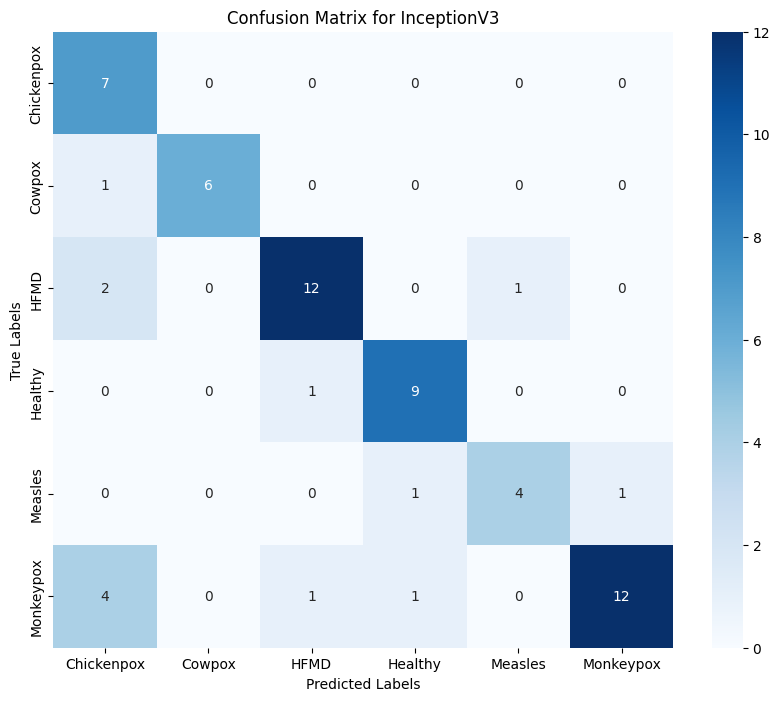

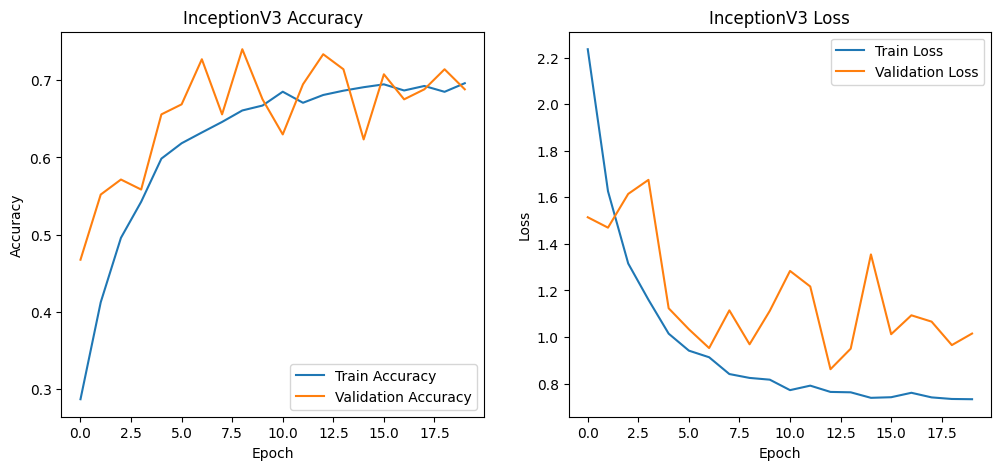

In [10]:
# Predictions on the test set
preds_inception = model_inception.predict(test_generator)
y_preds_inception = np.argmax(preds_inception, axis=1)
y_true_inception = test_generator.classes

# Classification report
print("Classification Report for InceptionV3 Model:")
print(classification_report(y_true_inception, y_preds_inception, target_names=test_generator.class_indices.keys()))

# Compute accuracy, precision, recall, and F1-score
accuracy_inception = accuracy_score(y_true_inception, y_preds_inception)
precision_inception = precision_score(y_true_inception, y_preds_inception, average='weighted', zero_division=0)
recall_inception = recall_score(y_true_inception, y_preds_inception, average='weighted', zero_division=0)
f1_inception = f1_score(y_true_inception, y_preds_inception, average='weighted', zero_division=0)

print(f"Precision: {precision_inception}")
print(f"Recall: {recall_inception}")
print(f"F1 Score: {f1_inception}")

# Confusion matrix
cm_inception = confusion_matrix(y_true_inception, y_preds_inception)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_inception, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for InceptionV3')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Function to plot training history
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot training history
plot_training_history(history_inception, model_name="InceptionV3")